# Non-linear Time Series Analysis


## Introduction

This report presents a nonlinear time series analysis of the provided dataset, following the requirements of the coursework. The analysis includes:
- Data loading and visualization
- Estimation of optimal time delay (τ)
- Calculation of the fractal dimension
- Determination of the minimum embedding dimension
- Estimation of the maximal Lyapunov exponent
- Nonlinear prediction and error analysis

Each section includes code and results along with explanations, where applicable. Comments are provided throughout the code to explain the rationale and methodology.

## 1. Data Loading and Initial Visualization

The first step is to load the provided time series data and visualize it to gain an initial understanding of its structure and characteristics. The data is in a single-column text file (`w20.dat`).

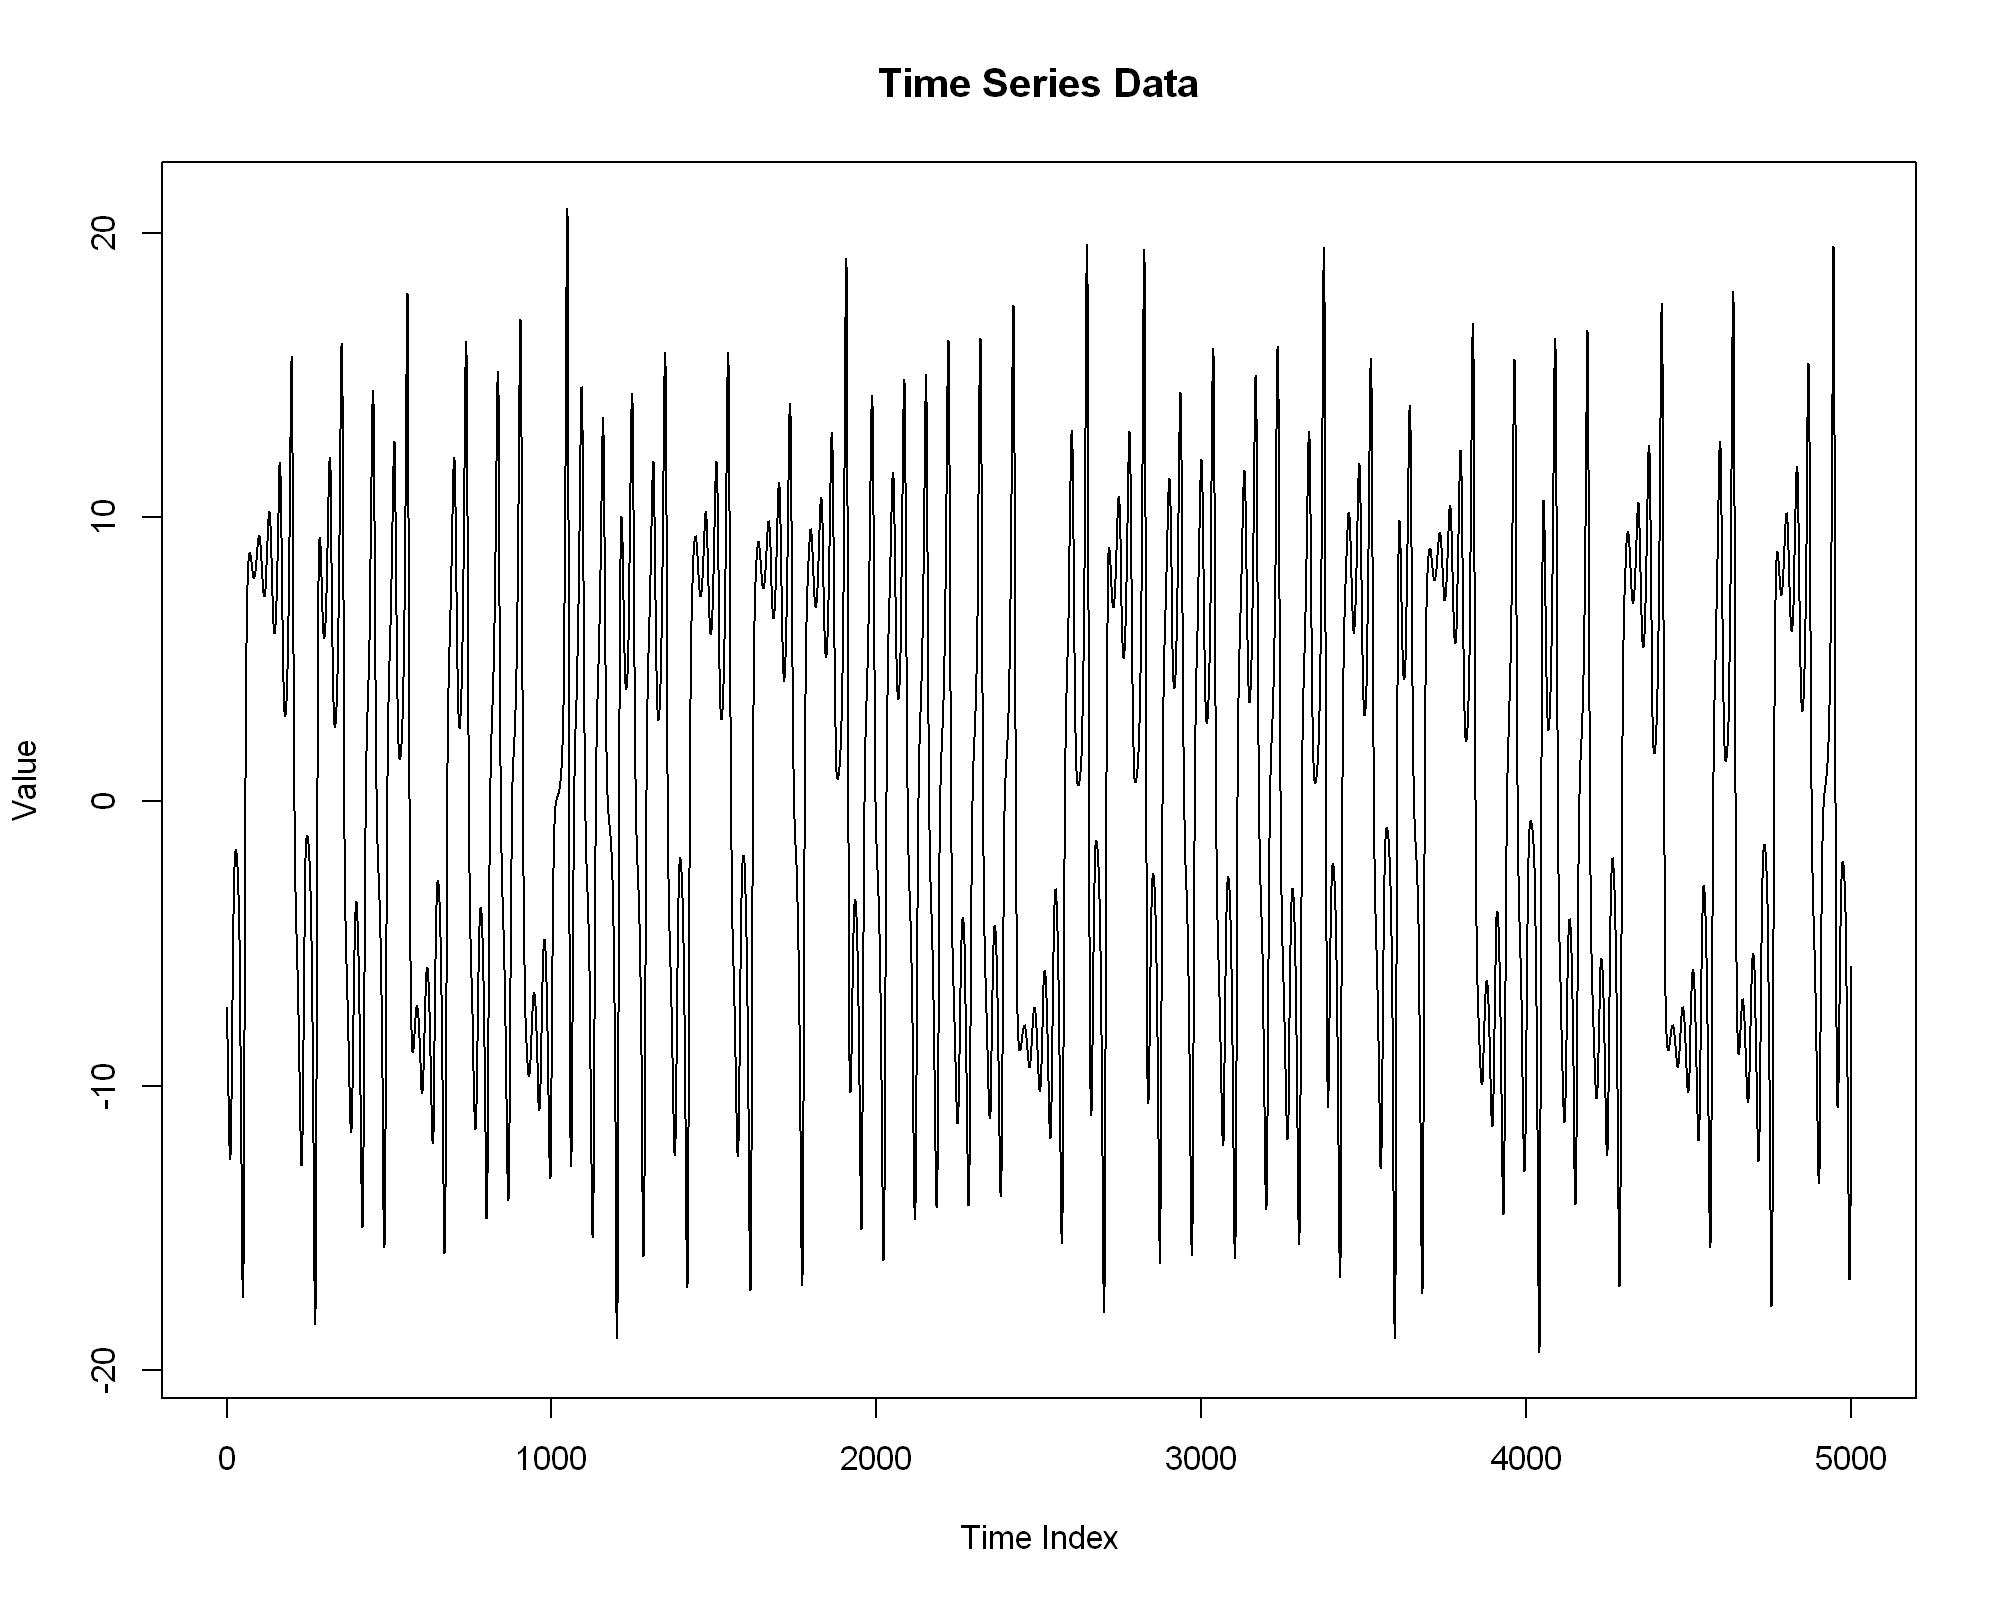

In [ ]:
# Load required libraries
library(readr)
library(tseriesChaos)
library(nonlinearTseries)

# Set plotting preferences
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

# Load the timeseries data from the provided file
x <- read_tsv("w20.dat", col_names = FALSE, show_col_types = FALSE)
x <- ts(x)  # Convert to time series object

# Visualize the time series to inspect for trends, periodicity, chaos etc.
plot(x, main = "Time Series Data", ylab = "Value", xlab = "Time Index")

## 2. Estimation of the Optimal Time Delay (τ)

To reconstruct the phase space of a dynamical system from a scalar time series, it is necessary to choose an appropriate time delay (τ). The time delay is estimated using the first local minimum of the mutual information function, which helps ensure that the reconstructed coordinates are sufficiently independent. This section computes and visualizes mutual information in order to select τ.

        0         1         2         3         4         5         6         7 
2.5421234 1.7457866 1.3475347 1.0760373 0.8863921 0.7470064 0.6514958 0.5907133 
        8         9        10        11        12        13        14        15 
0.5713847 0.5852602 0.6333632 0.6819362 0.7476817 0.7823968 0.7842745 0.7732579 
       16        17        18        19        20        21        22        23 
0.7528307 0.7115425 0.6600634 0.6148863 0.5635100 0.5109524 0.4544153 0.3955531 
       24        25        26        27        28        29        30        31 
0.3503708 0.3152744 0.2877347 0.2697380 0.2715583 0.2931542 0.3196524 0.3569985 
       32        33        34        35        36        37        38        39 
0.3909369 0.4245487 0.4407249 0.4477495 0.4300736 0.4017900 0.3764071 0.3493092 
       40        41        42        43        44        45        46        47 
0.3242787 0.2955298 0.2753334 0.2724173 0.2785893 0.3003181 0.3266654 0.3508372 
       48        49        5

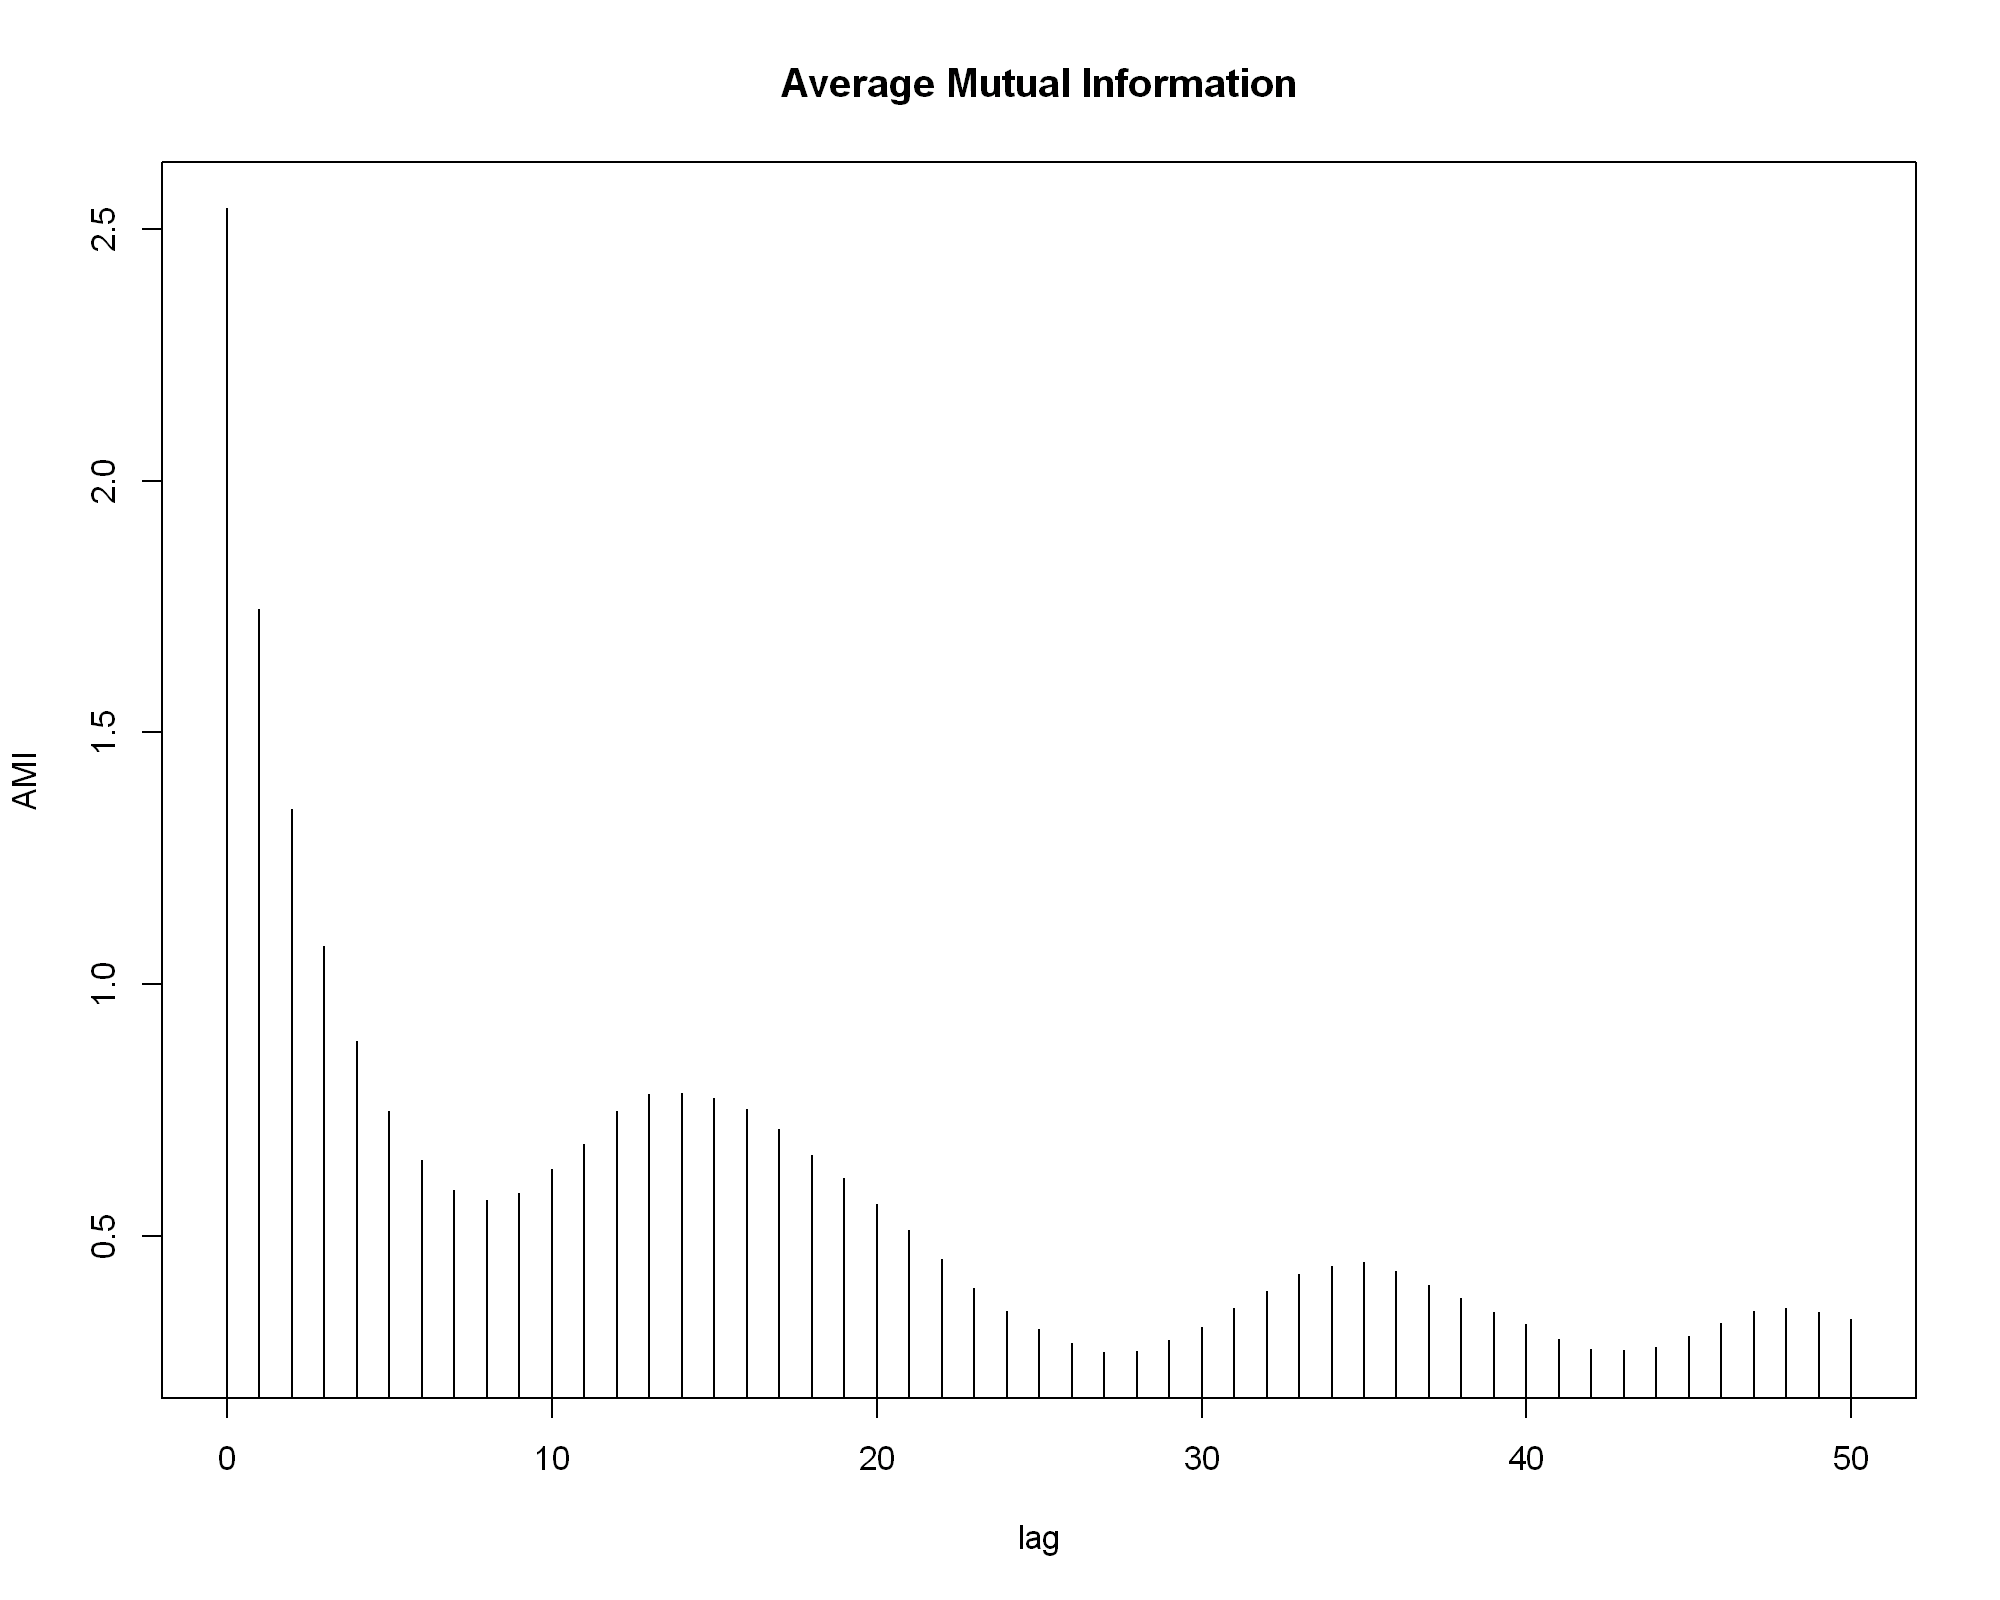

In [13]:
# Calculate the mutual information for a range of lags 
mutual = mutual(x, partitions = 16, lag.max = 50, plot=TRUE)  # partitions: number of bins
print(mutual)  # for inspection of values

**Result:**

The first local minimum of the mutual information plot suggests that the optimal time delay for phase space reconstruction is τ = 8. This value will be used by hardcoding it in subsequent analyses.

## 3. Fractal Dimension Analysis

The fractal dimension of the attractor underlying the time series quantifies the complexity of the system and helps distinguish between stochastic and deterministic chaos. The Grassberger-Procaccia algorithm is used here, to estimate the fractal dimension by analyzing how the number of point pairs within a certain radius scales with the radius, across different embedding dimensions.

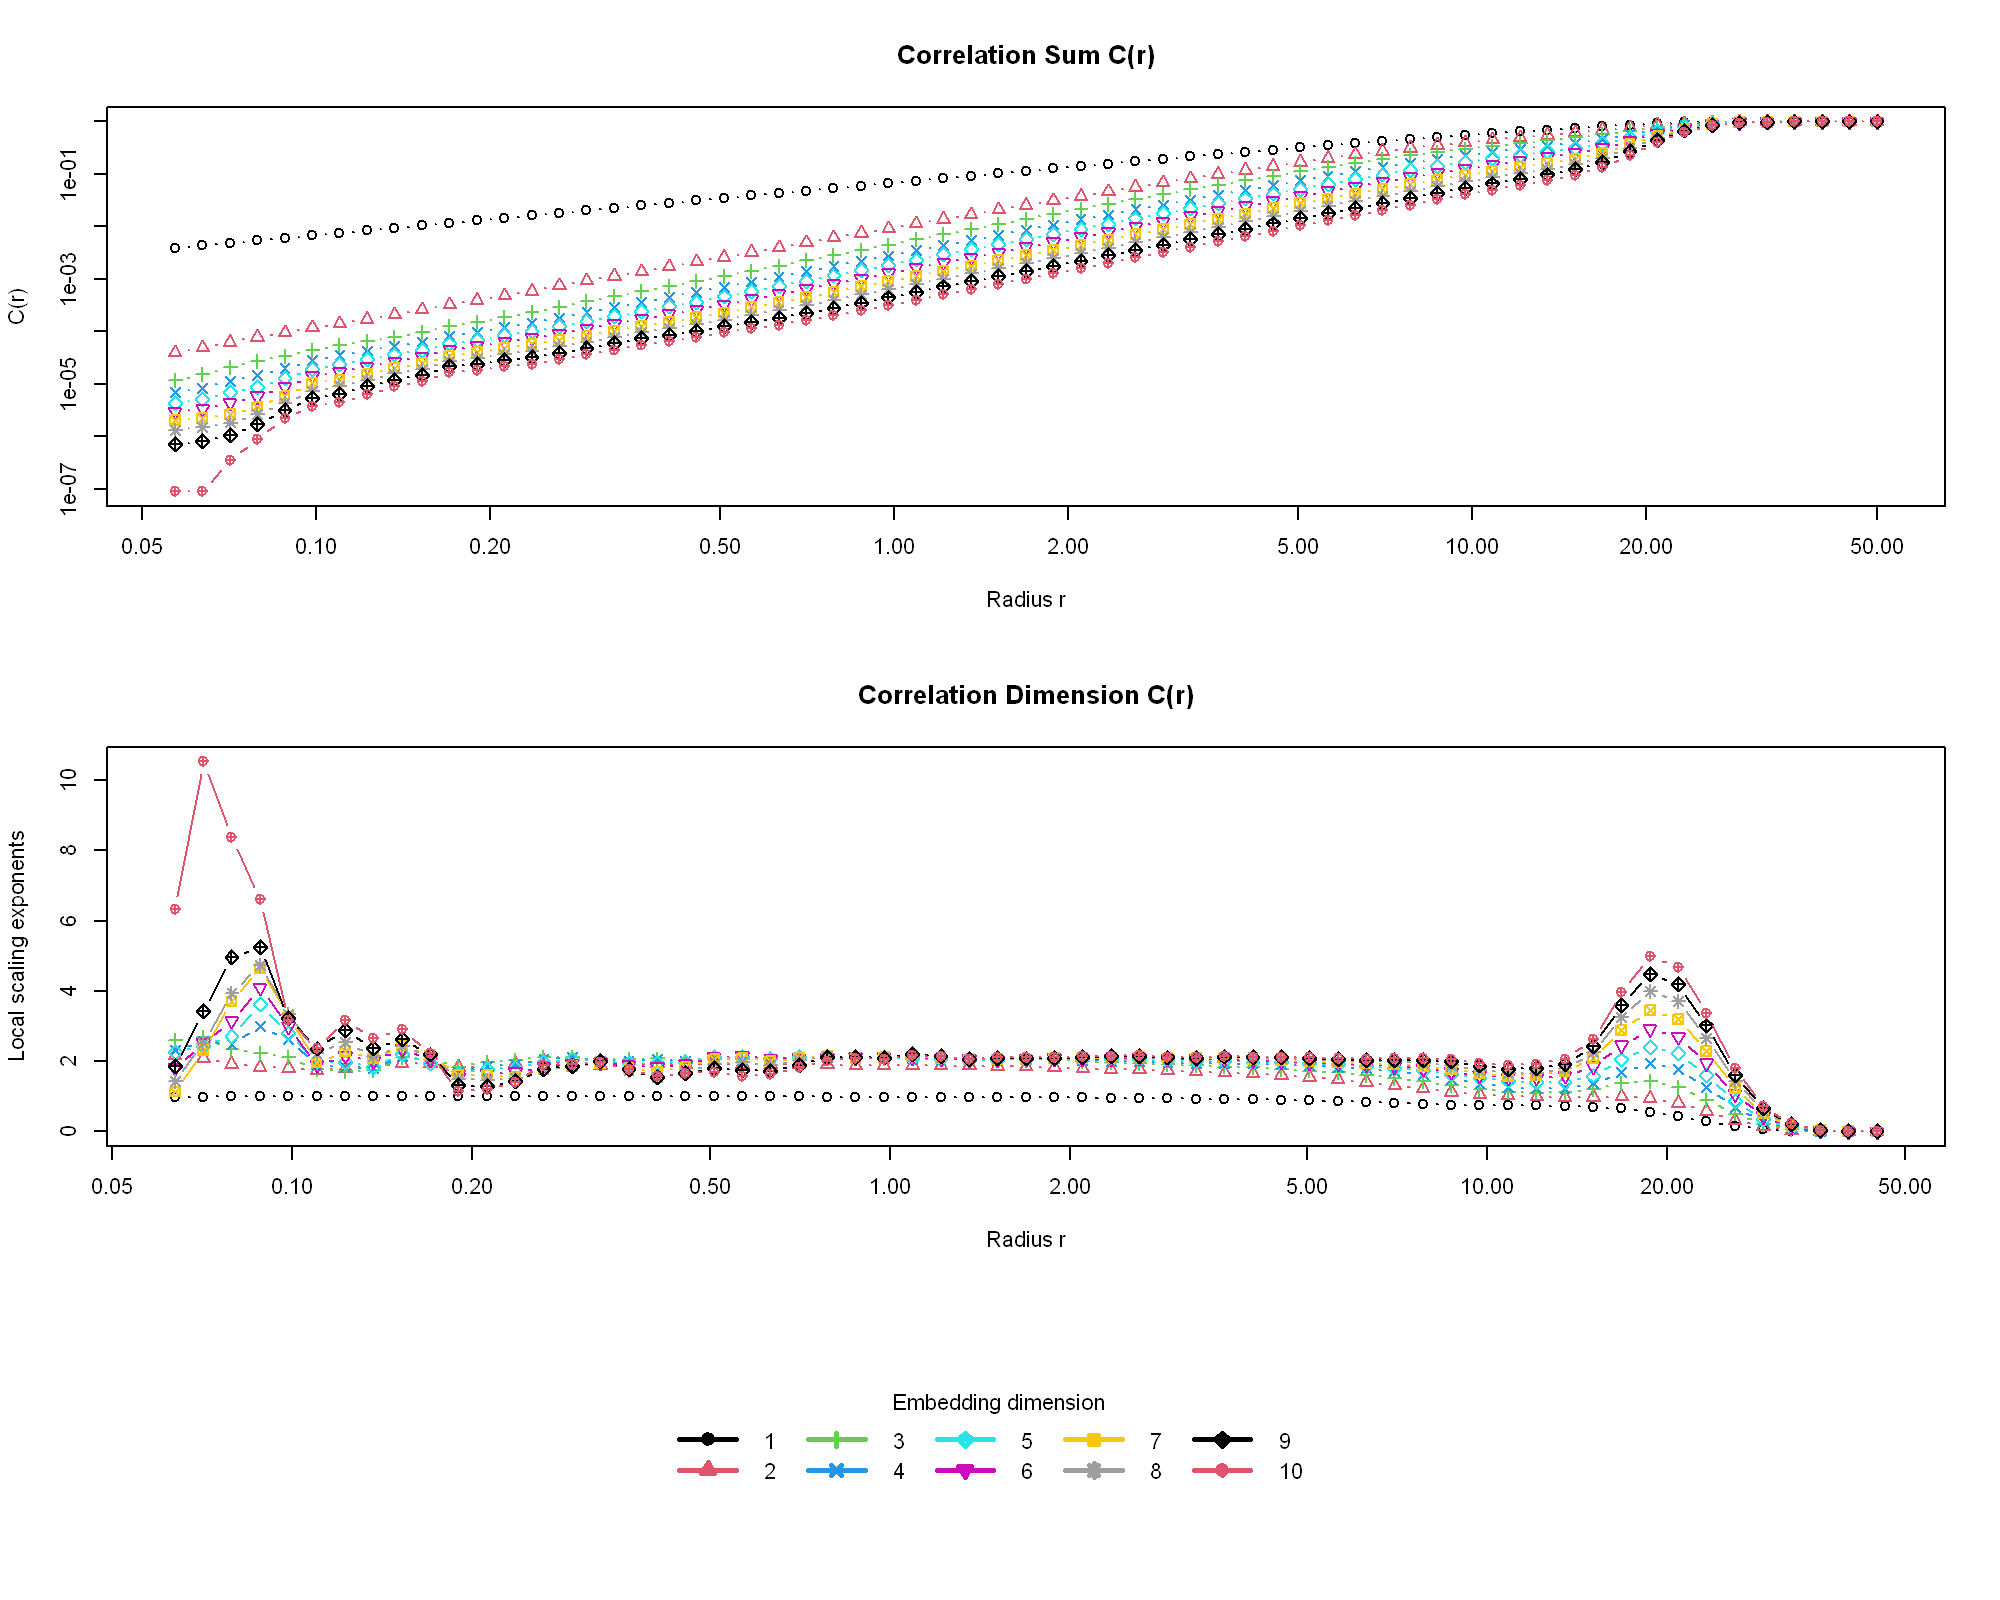

In [14]:
# Compute the correlation integral at increasing embedding dimensions using the Grassberger-Procaccia algorithm
cd = corrDim(
  time.series = x,
  min.embedding.dim = 1,   # Start with embedding dimension 1
  max.embedding.dim = 10,  # Up to embedding dimension 10
  time.lag = 8,            # Use the previously determined optimal delay
  min.radius = 1e-3,       # Minimum radius for correlation sum
  max.radius = 50,         # Maximum radius
  n.points.radius = 100,   # Number of radius values to evaluate
  theiler.window = 100,    # Theiler window to exclude temporally correlated points
  number.boxes = 100,      # Number of boxes for partitioning (for speed I think)
  do.plot = TRUE           # Show the default log-log plot and local scaling exponent
)

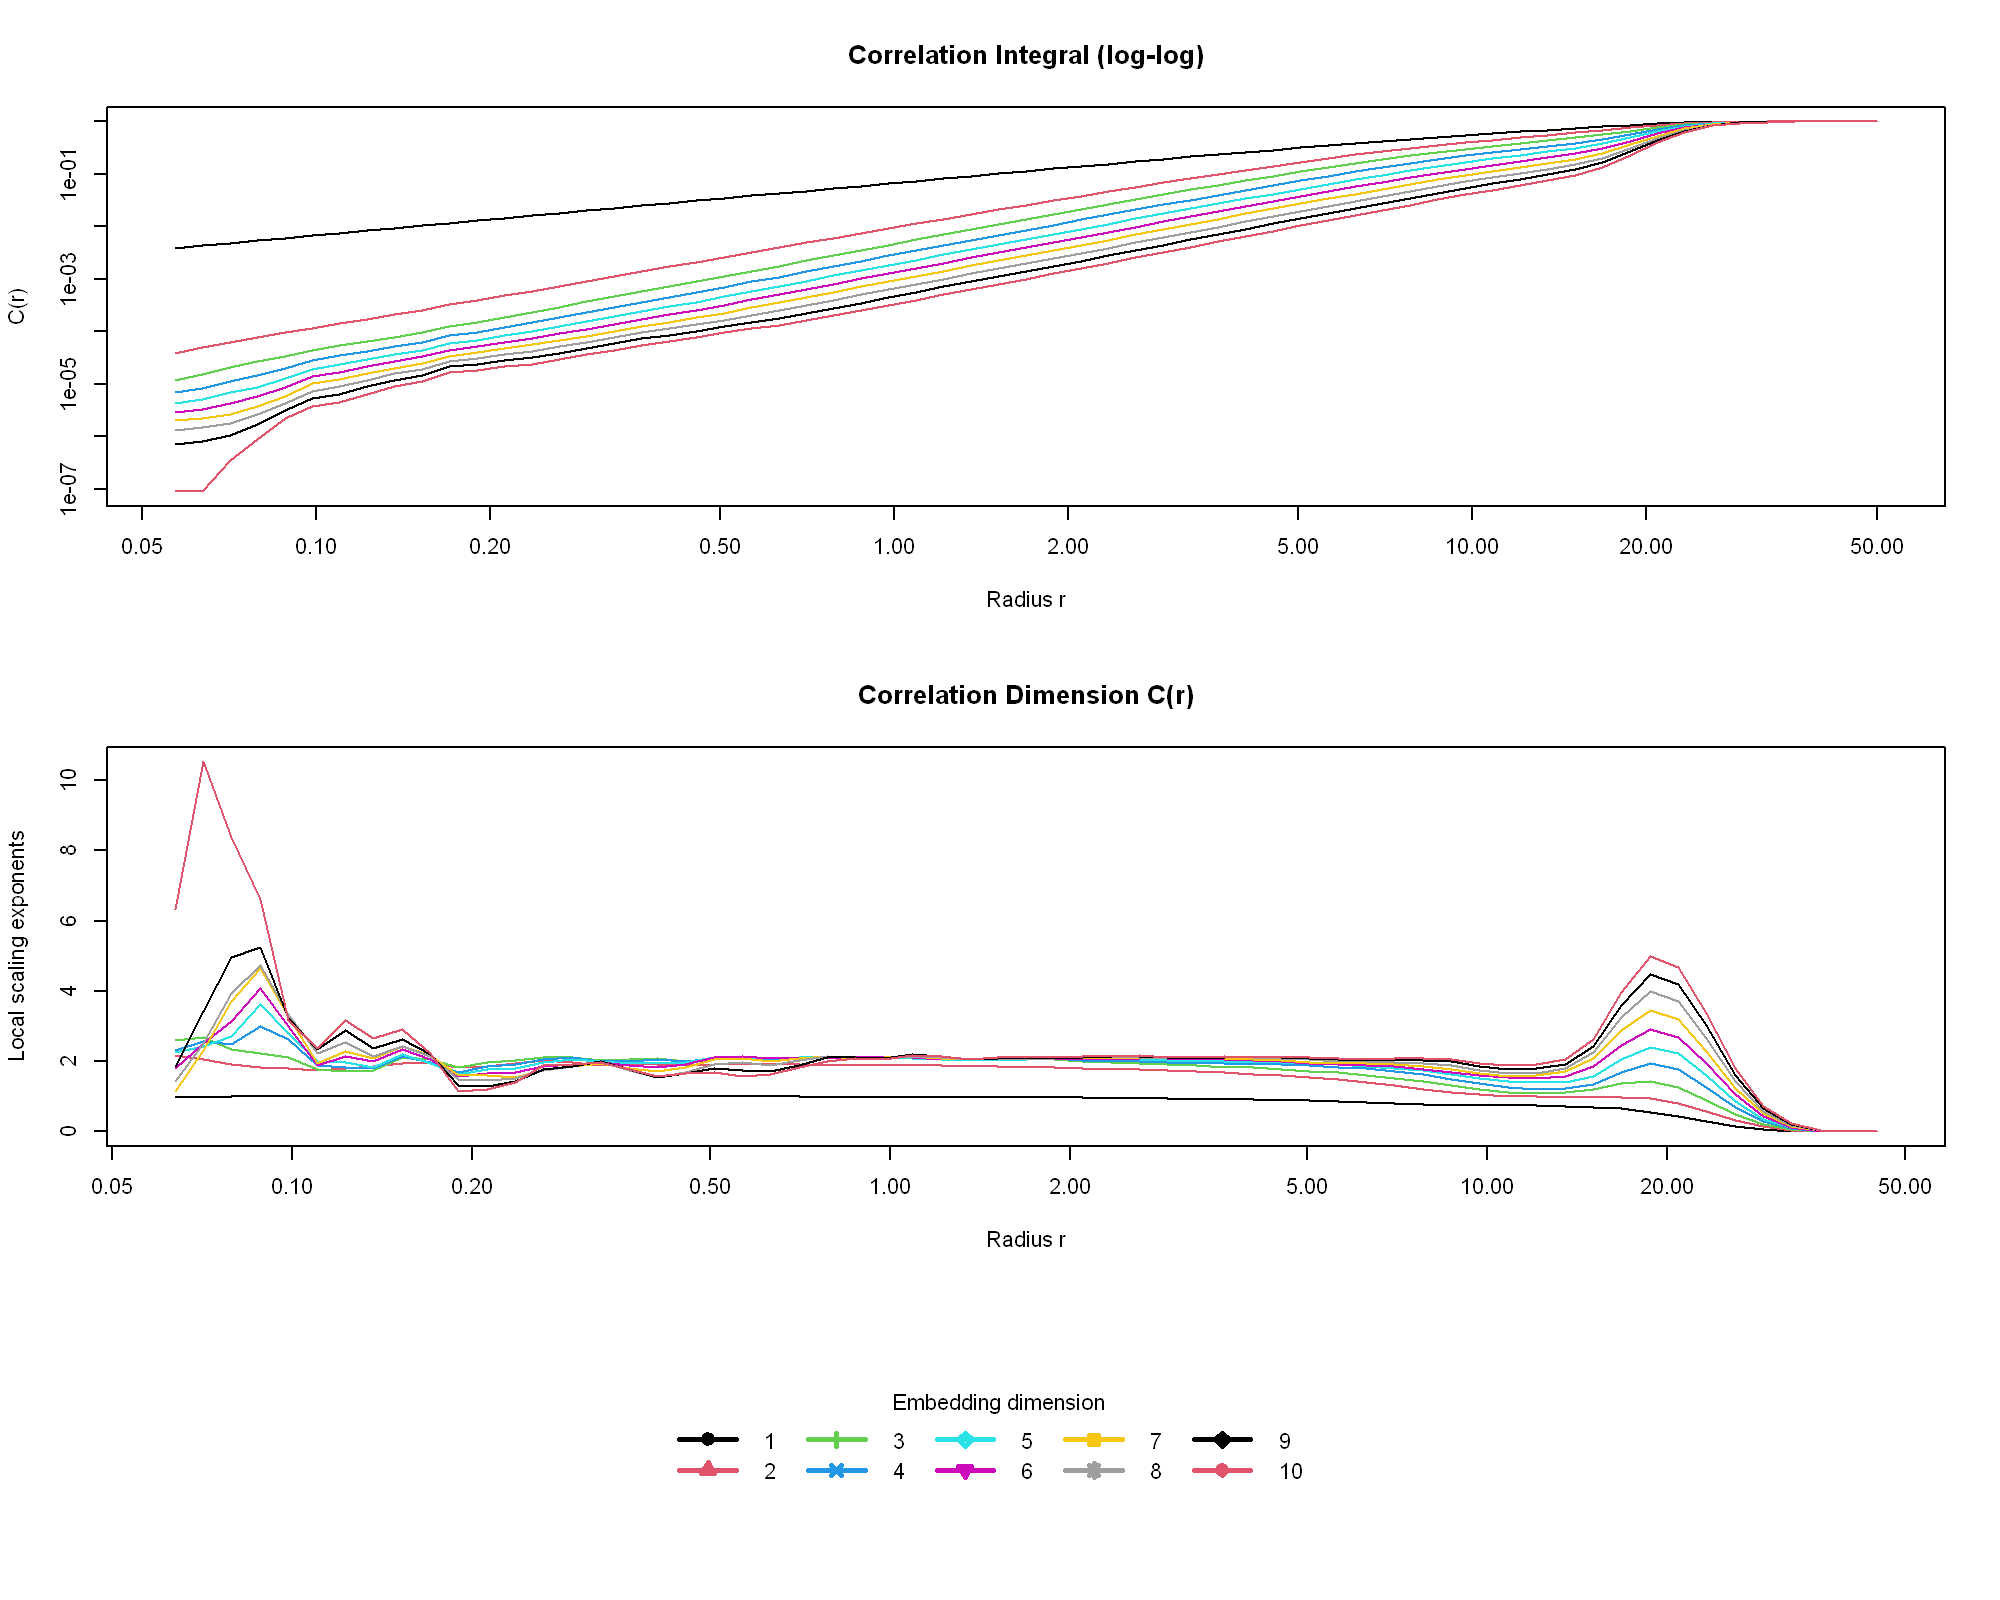

In [15]:
# For better visualization, plot them as plain lines too.
plot(cd, type = "l", main = "Correlation Integral (log-log)")

We focus on the local scaling exponent (slope of the log-log plot) in the region where the slope looks more stable.
This will help identify the scaling region where the fractal dimension can be reliably estimated.

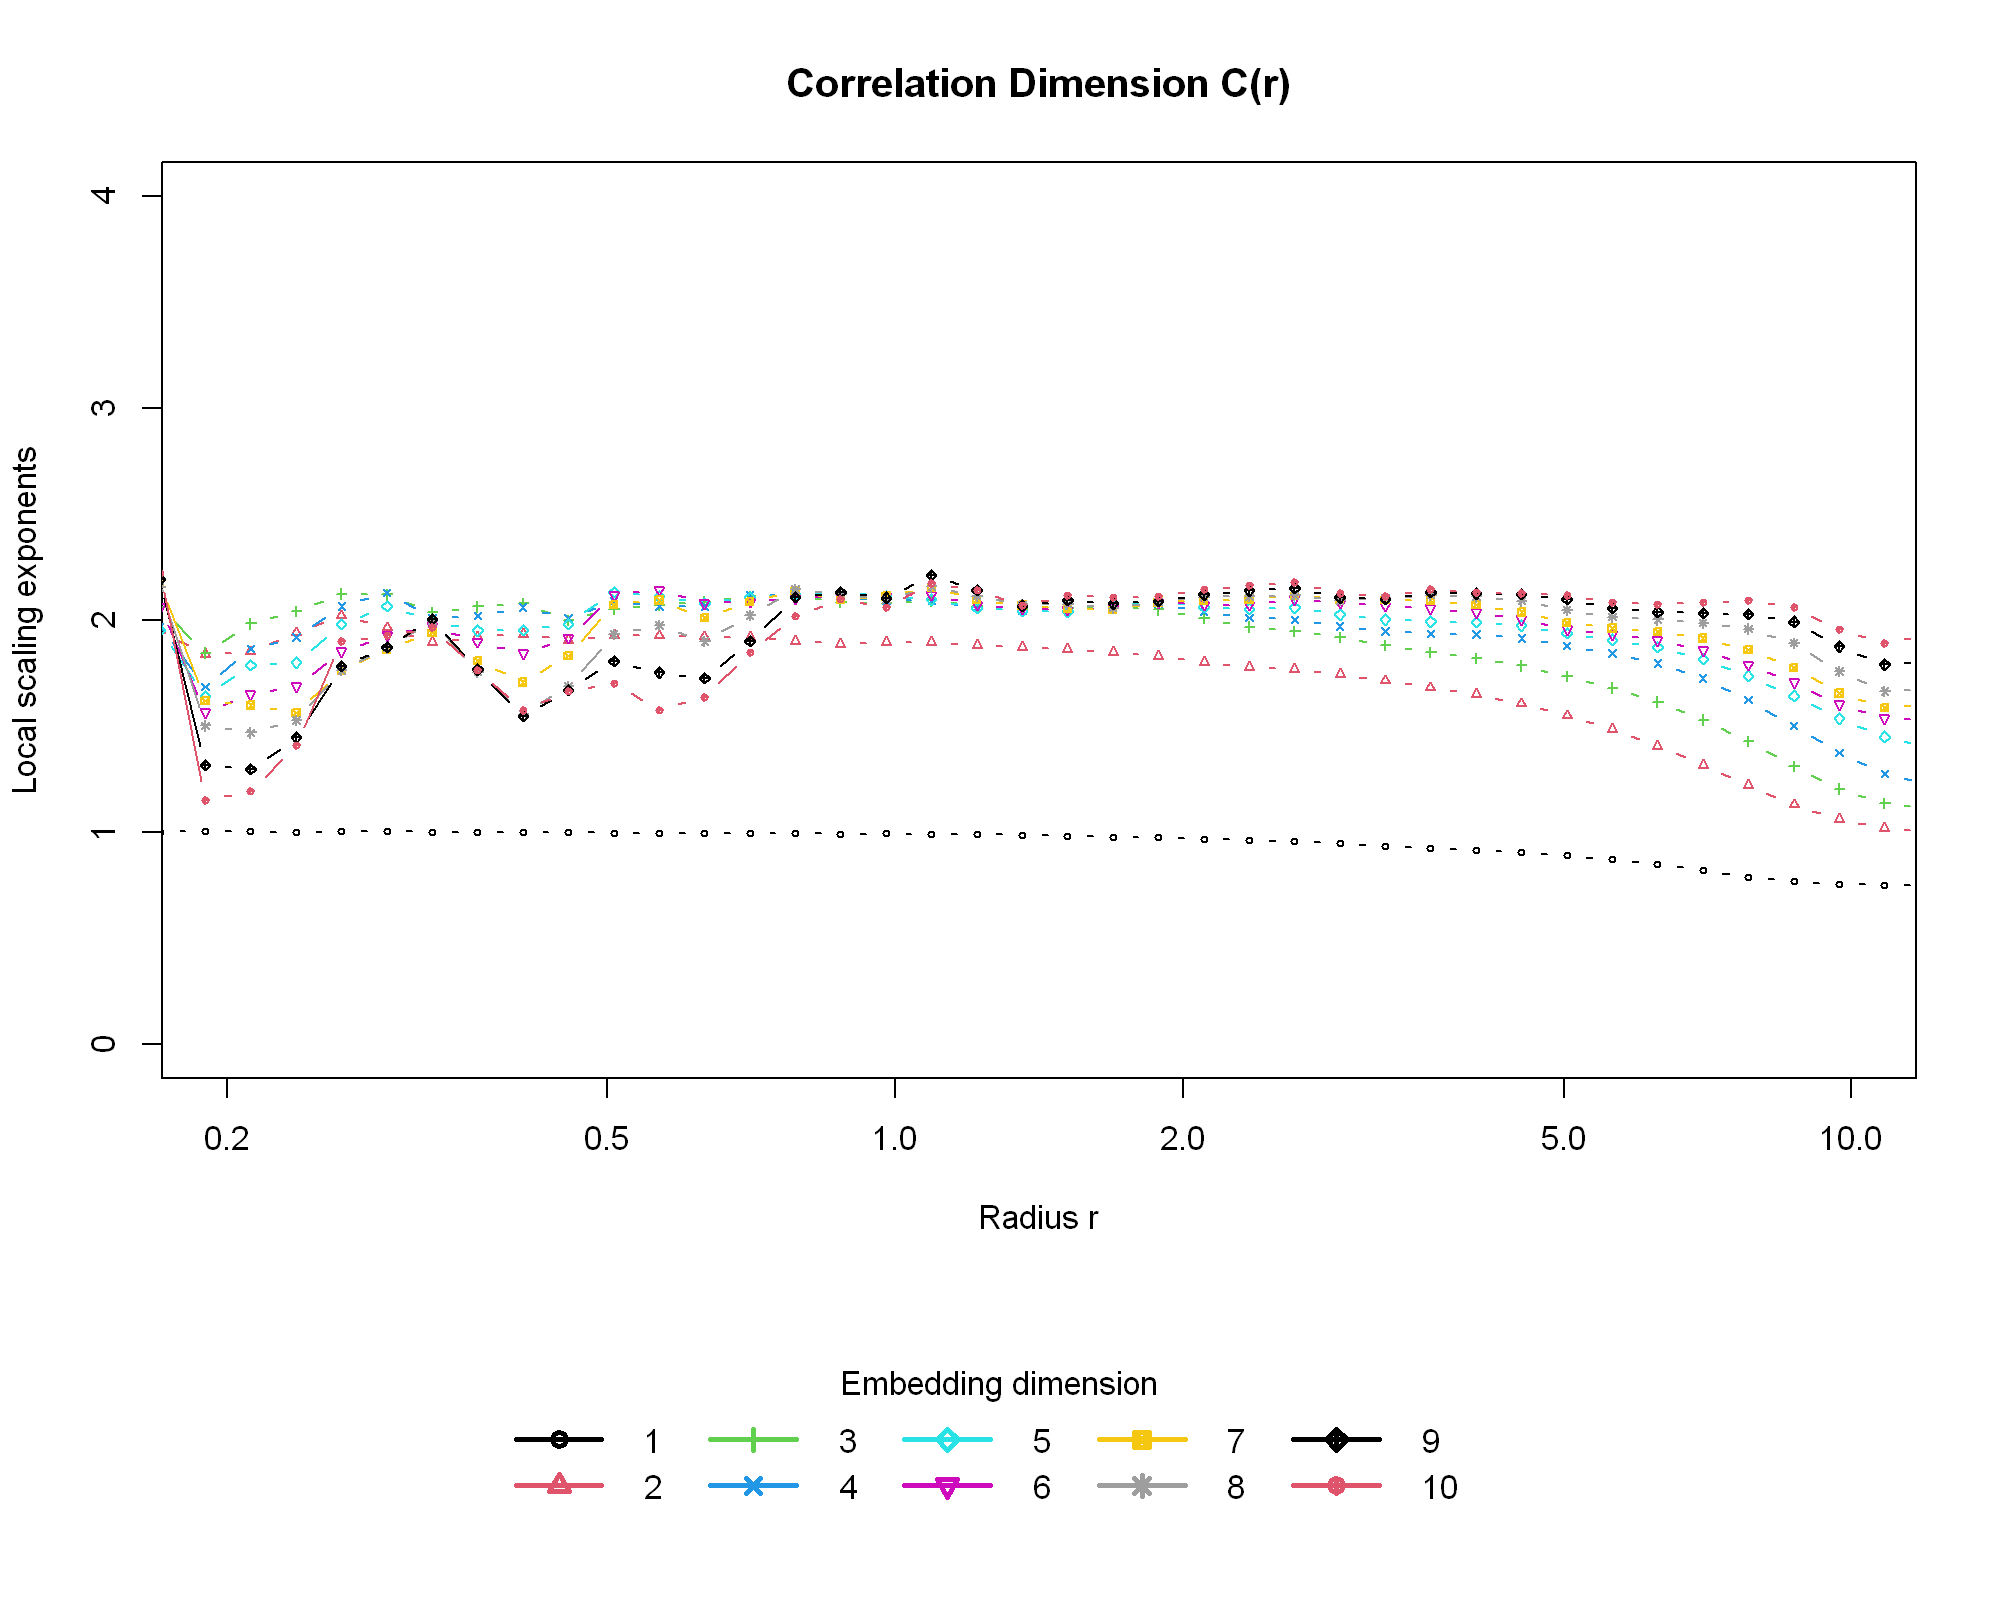

In [16]:
plotLocalScalingExp(cd, cex=0.5, xlim=c(0.2, 10), ylim=c(0, 4))

We estimate the fractal dimension by fitting a line to the most stable region of the local scaling exponent plot, essentially estimating the slope.

In [17]:
cd.est = estimate(cd, regression.range = c(1, 5))  # regression.range specifies the radius interval used for the linear fit
cat("Fractal dimension estimate: ", cd.est, "\n")

Fractal dimension estimate:  1.927602 


## 4. Minimum Embedding Dimension Estimation

The minimum embedding dimension is the smallest dimension in which the attractor can be unfolded without self-intersections. Estimating this dimension is crucial for accurate phase space reconstruction and subsequent nonlinear analysis. The false nearest neighbors (FNN) method is commonly used for this purpose.

embedding dimension estimate:  5 


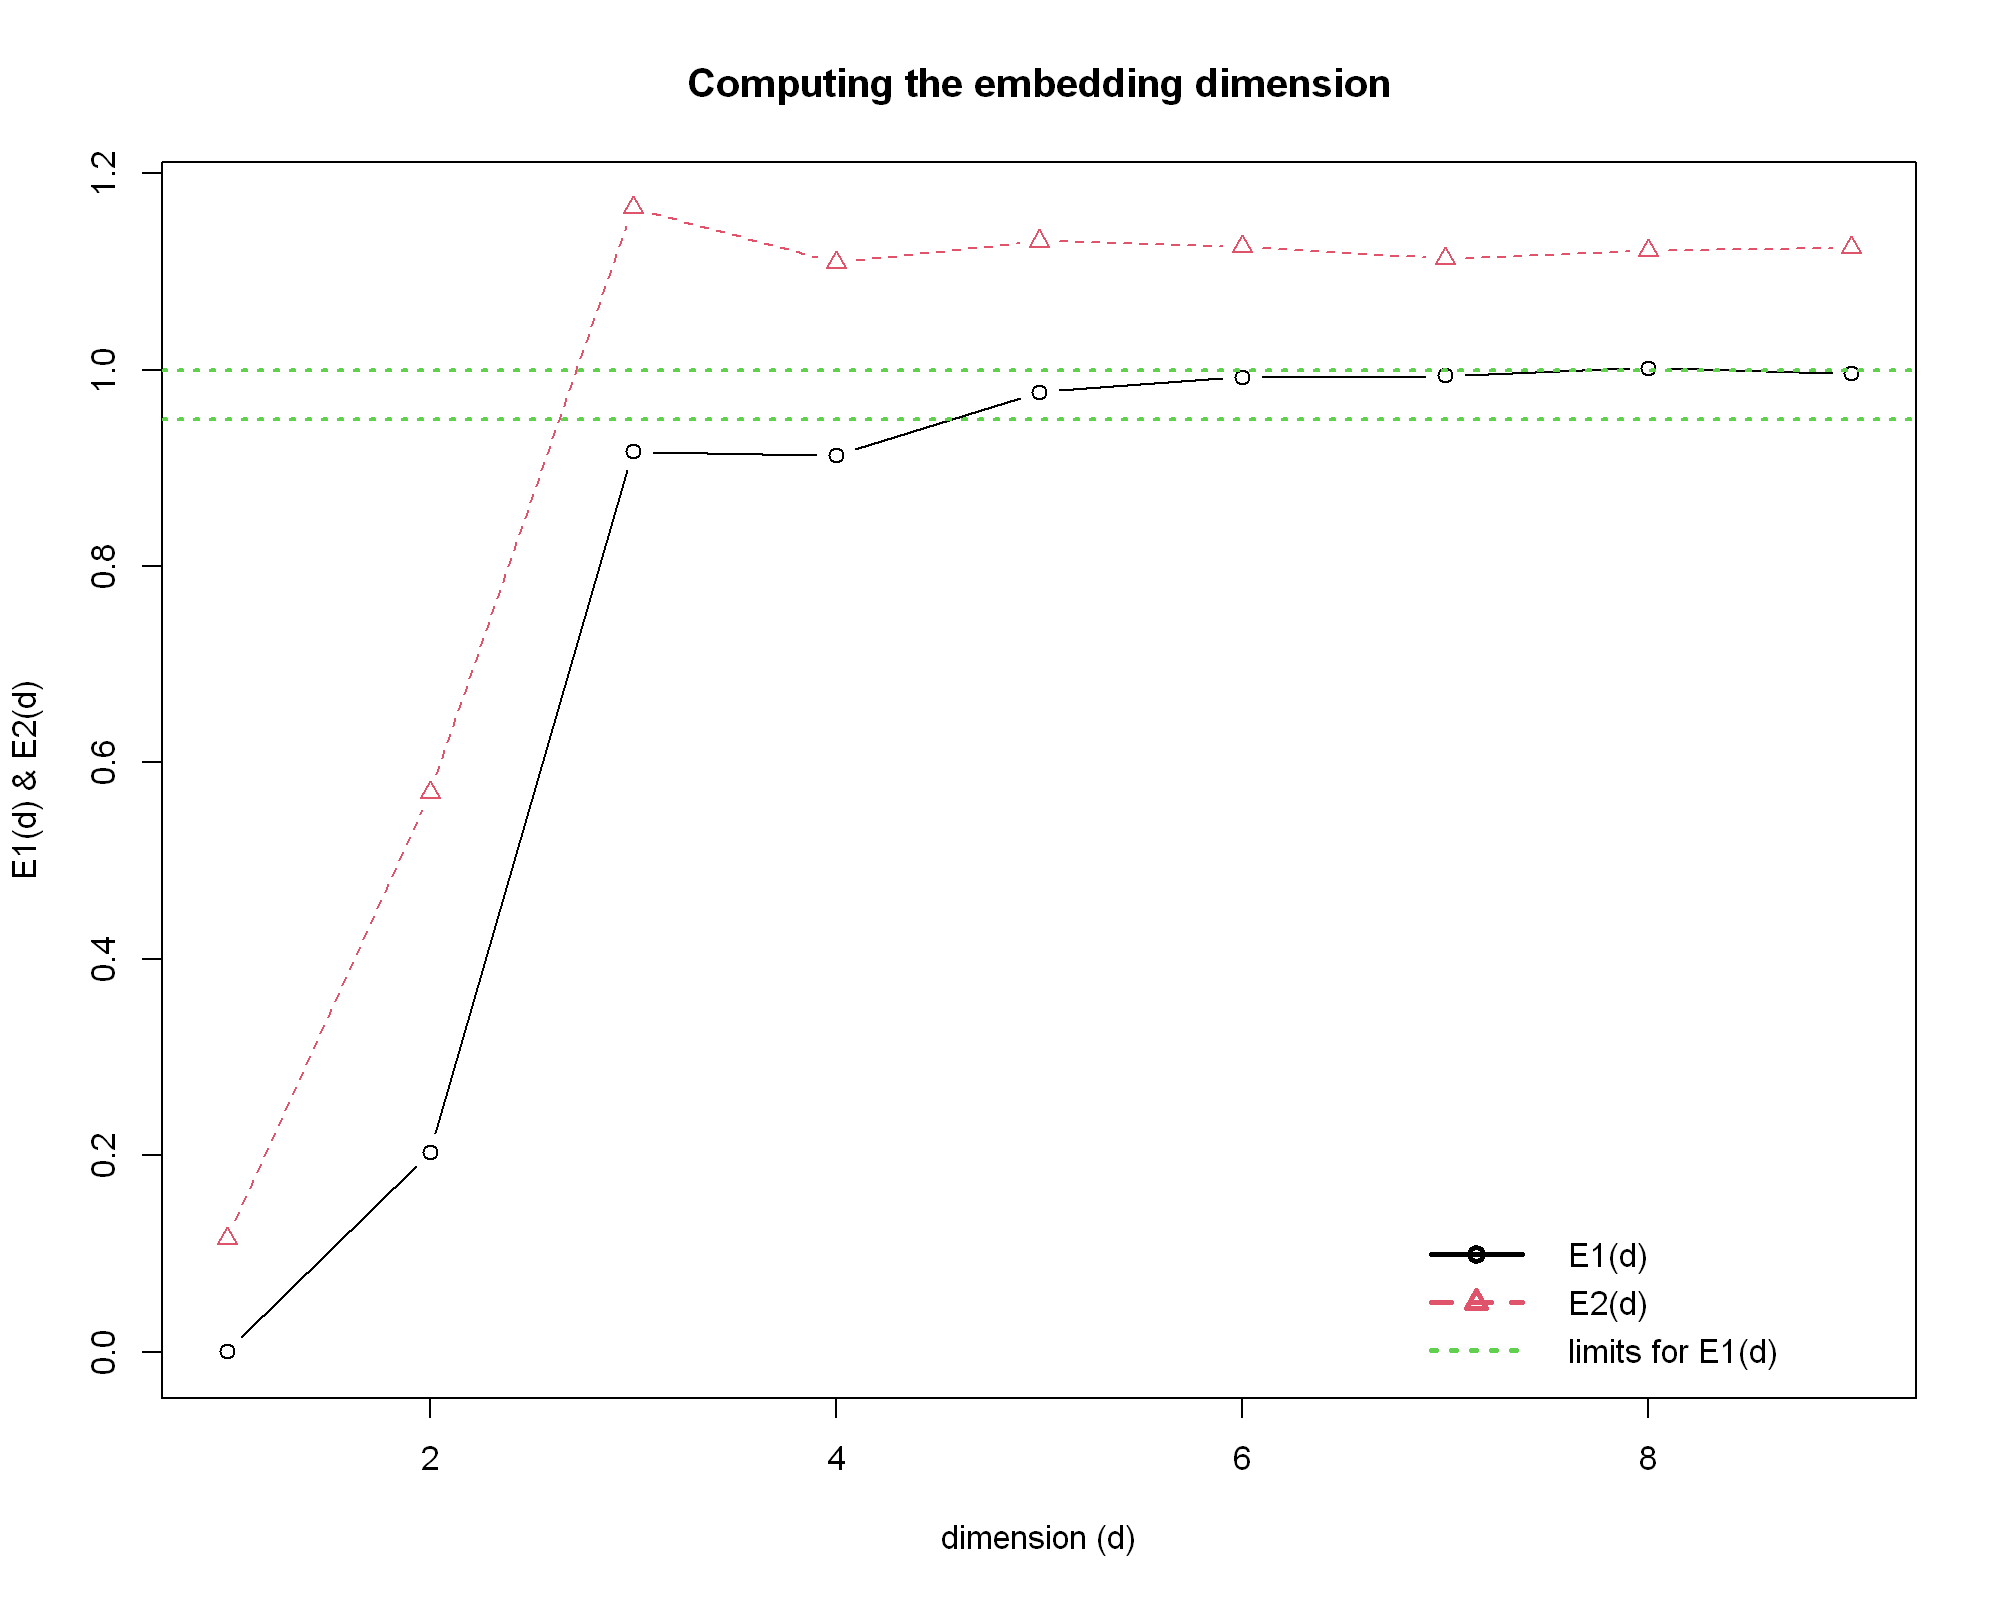

In [18]:
dimension = estimateEmbeddingDim(x, time.lag=8, max.embedding.dim=10, threshold=0.95, do.plot=TRUE)
cat("embedding dimension estimate: ", dimension, "\n")

**Result:**

The estimated minimum embedding dimension is 5 (using a rather strict threshold of 0.95 for the fraction of false nearest neighbors). This value will be used for phase space reconstruction and further nonlinear analysis.

## 5. Maximal Lyapunov exponent estimation

  |======================================================================| 100%
 Best models: 
  m lag  h      BIC
6 5   8  7 2.043692
8 5   8  9 2.122690
7 5   8  8 2.336571
9 5   8 10 2.629046
3 5   8  4 2.710994
4 5   8  5 2.739010
5 5   8  6 2.828596
2 5   8  3 2.963154
1 5   8  2 2.995560
Call:
Largest Lyapunov exponent 

Coefficients:
          Estimate Std. Error z value Pr(>|z|)
Exponent 0.1032602 0.08859675 11.8859        1
---
Procedure: Norma-2 by bootstrap blocking method 
Embedding dimension: 5, Time-delay: 8, No. hidden units: 7
Sample size: 4944, Block length: 104, No. blocks: 100

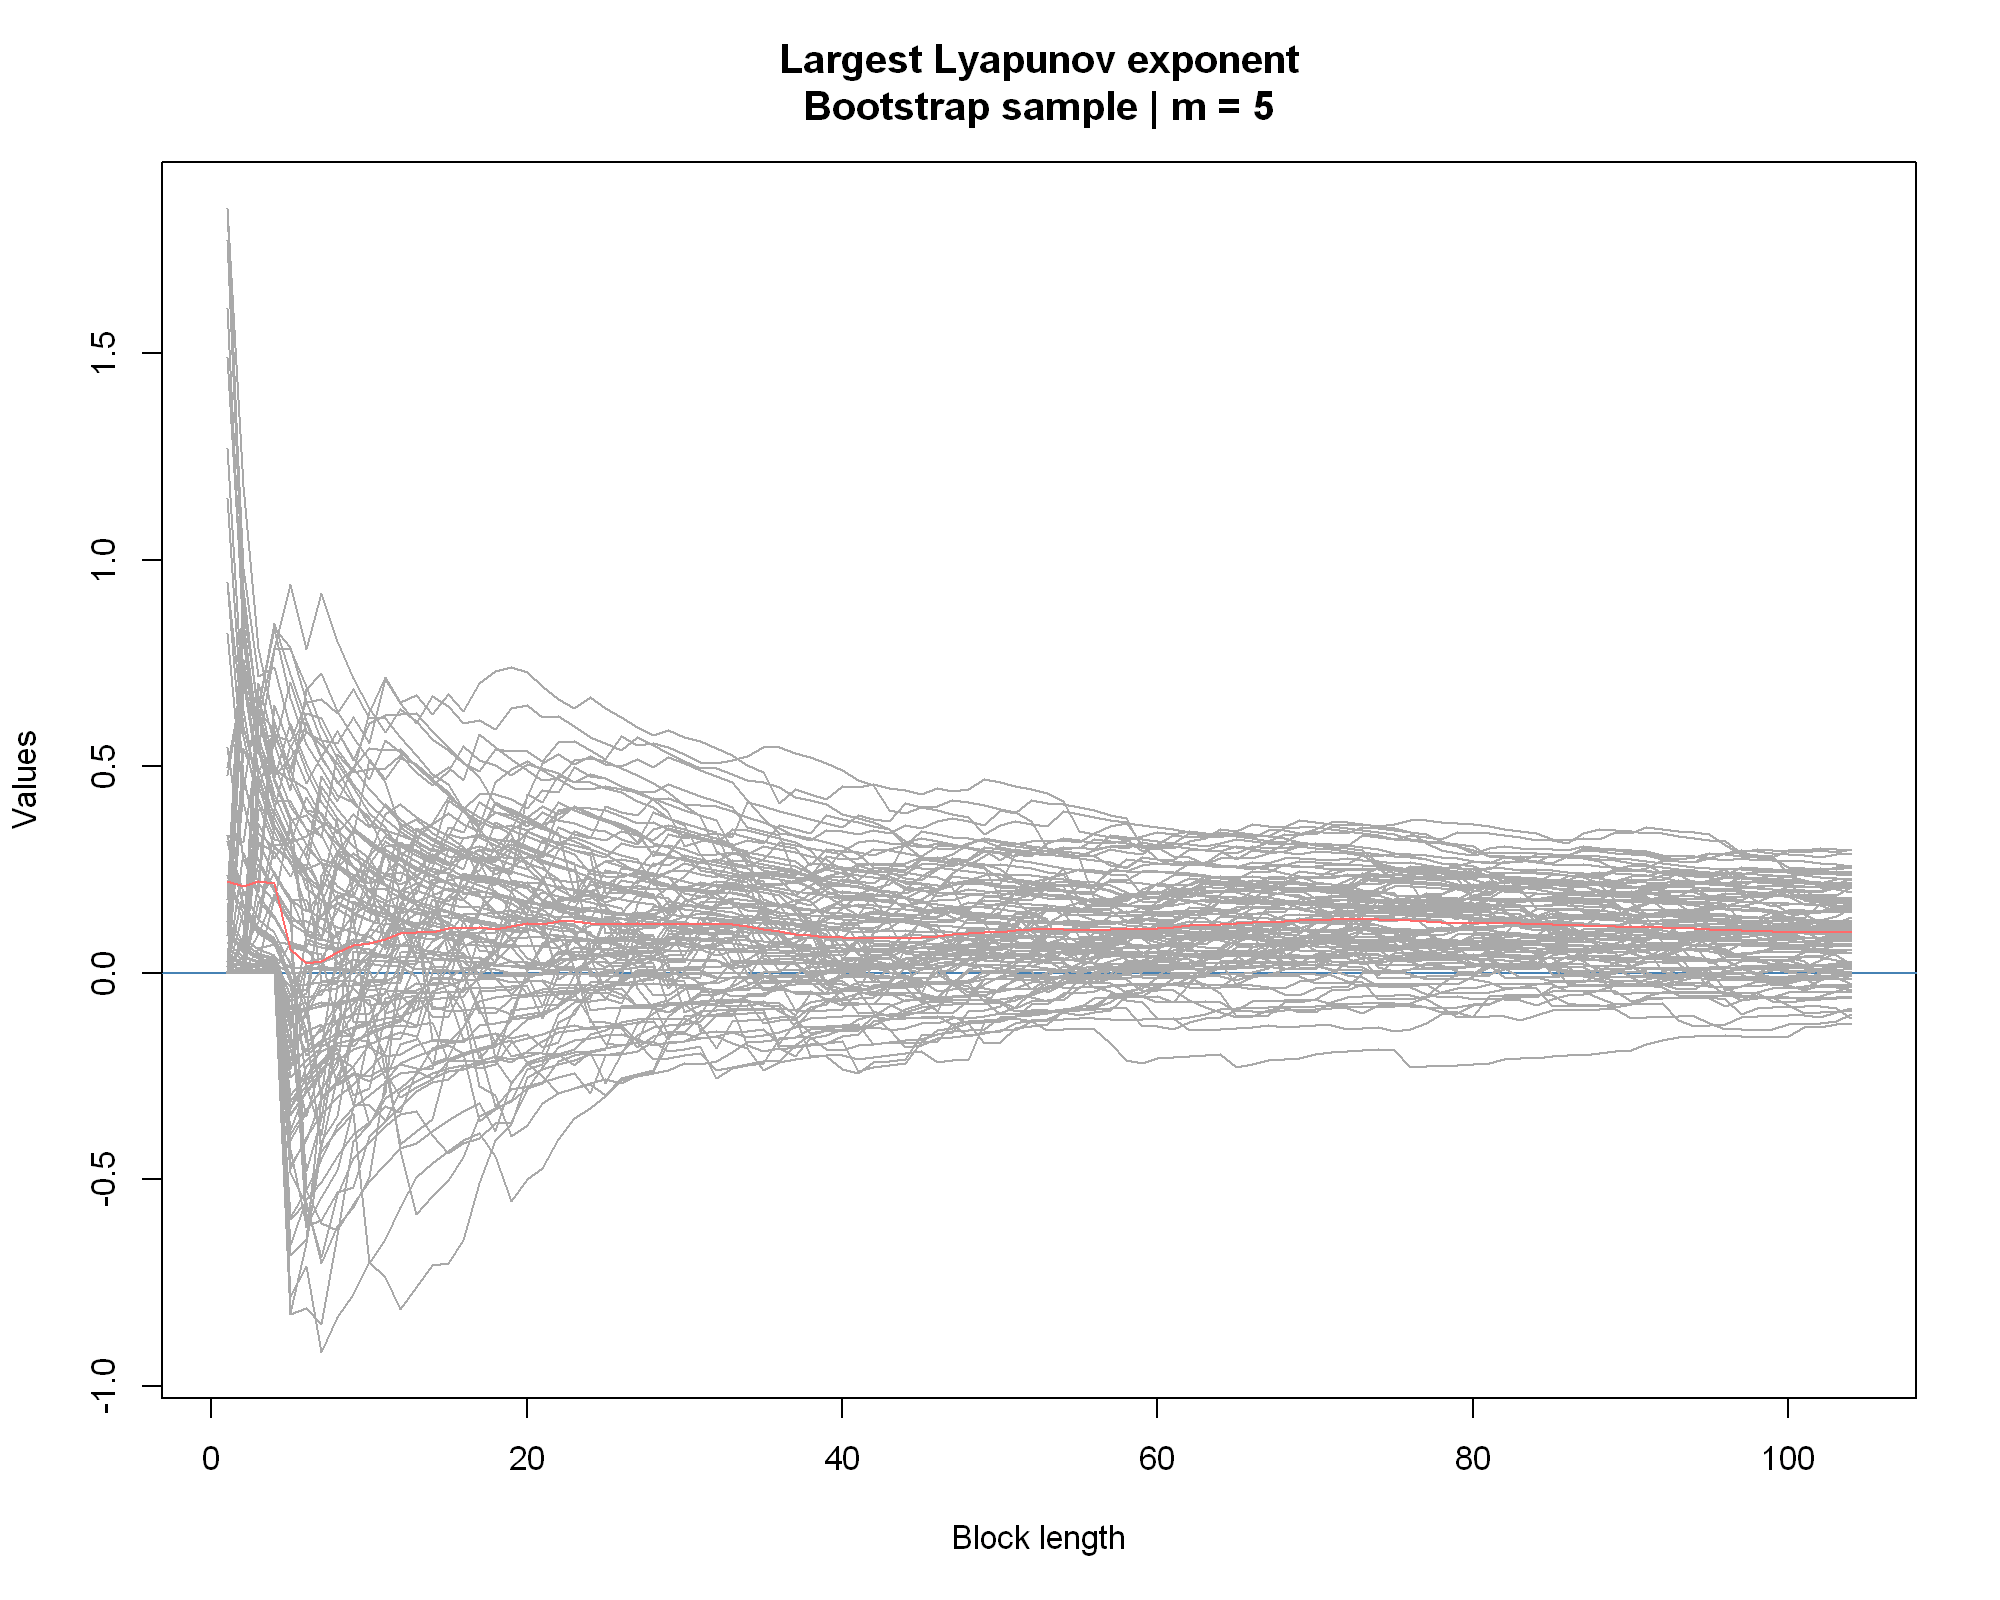

In [19]:
# Estimate the maximal Lyapunov exponent using the Jacobian method
jacobian <- DChaos::jacobian.net(data=x, m=5, lag=8, timelapse="FIXED", h=2:10)
exponent <- DChaos::lyapunov.max(data=jacobian, blocking="BOOT", B=100, doplot=TRUE)
summary(exponent)

Finding nearests
Keeping  3300  reference points
Following points


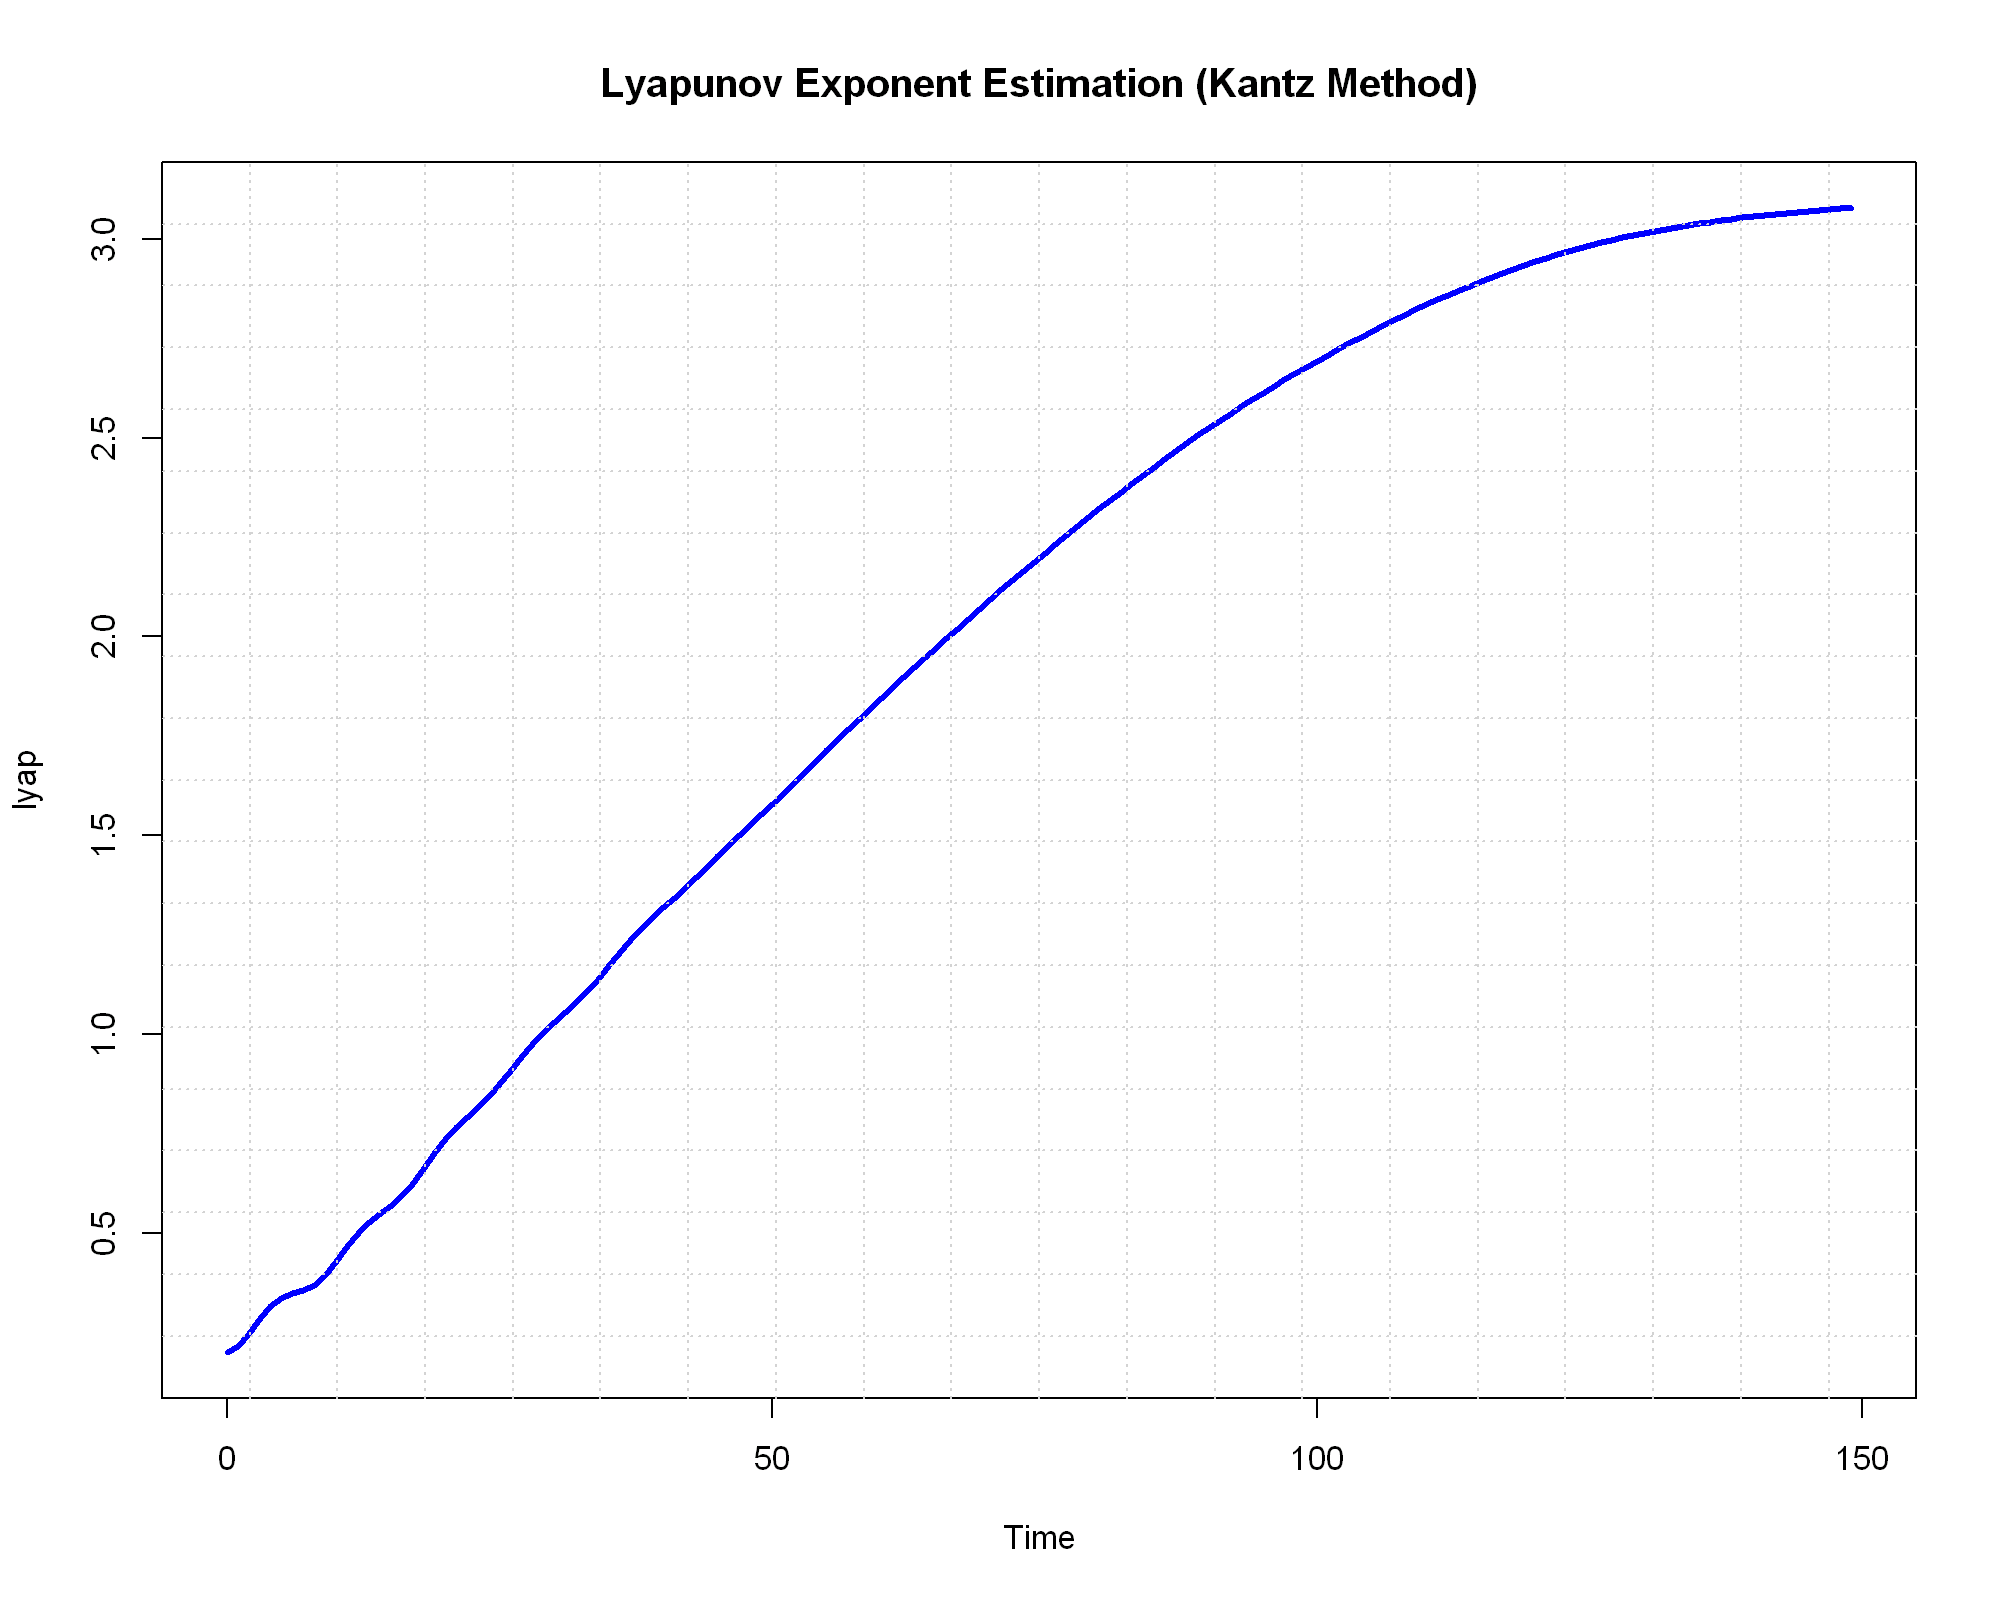

In [20]:
# Estimate the maximal Lyapunov exponent using the Kantz method 
ref1 = length(x)
lyap = lyap_k(x, m=5, d=8, s=150, t=0, ref=ref1*0.7, k=12, eps=4)
plot(lyap, main = "Lyapunov Exponent Estimation (Kantz Method)", col = "blue", lwd = 3)
grid(nx = 20, ny = 20)

As before, we estimate based on the region where the slope looks more stable.

In [21]:
lyap(lyap, 50, 100)  # Arguments specify the range of points for the linear fit

(Intercept)      lambda 
 0.49656679  0.02251421

**Result:**

The maximal Lyapunov exponent that was estimated using the two methods is:

- Jacobian-based method: λ ≈ 0.103 (Std. Error ≈ 0.089)
- Kantz method: λ ≈ 0.023

The numerical values differ, as expected due to methodological differences, however both estimates are positive, which is the key indicator. This suggests that nearby trajectories in the reconstructed phase space diverge exponentially over time, thereby confirming the presence of chaotic behavior in the system.


## 6. Nonlinear Prediction and Error Analysis

In this section, we use the reconstructed attractor to predict the next value in the time series using nonlinear forecasting methods. The prediction is compared to the true value, and the relative error is calculated.

In [22]:
# Prepare the training set by excluding the last value
train_length <- length(x) - 1
train_series <- x[1:train_length]
true_value <- x[length(x)]  # The actual next value to predict

# Perform nonlinear prediction using the reconstructed attractor
forecast_value <- nonLinearPrediction(
  time.series = train_series,
  embedding.dim = 5,        # the estimated minimum embedding dimension
  time.lag = 8,             # the optimal delay
  prediction.step = 1,      # one step ahead
  radius = 0.03 * sd(x),    # Neighborhood radius (scaled to data)
  radius.increment = 0.03 / 2  * sd(x)  # Increment for searching neighbors
)

# Calculate the absolute and relative prediction error
error <- true_value - forecast_value
relative_error <- (abs(error) / abs(true_value)) * 100

cat(sprintf("Predicted value at time %d: True = %.6f | Predicted = %.6f | Error = %.6f | Rel. Error = %.2f%%\n",
            length(x), true_value, forecast_value, error, relative_error))

Predicted value at time 5000: True = -5.784488 | Predicted = -5.615517 | Error = -0.168971 | Rel. Error = 2.92%


**Result:**

A relative prediction error of 2.92% indicates good predictive performance, especially for a nonlinear chaotic system.

**Discussion:**

Further improvements could be achieved by:
- Testing higher embedding dimensions
- Tuning the radius and radius increment parameters
- Trying alternative prediction algorithms
- Preprocessing the time series (e.g., detrending, normalization)



Just for fun, the next cell explores the effect of increasing the embedding dimension.

In [23]:
# Repeat the nonlinear prediction with a higher embedding dimension
forecast_value <- nonLinearPrediction(
  time.series = train_series,
  embedding.dim = 6,     # Increased embedding dimension
  time.lag = 8,
  prediction.step = 1,
  radius = 0.03 * sd(x),
  radius.increment = 0.03 / 2  * sd(x)
)

error <- true_value - forecast_value
relative_error <- (abs(error) / abs(true_value)) * 100

cat(sprintf("Predicted value at time %d: True = %.6f | Predicted = %.6f | Error = %.6f | Rel. Error = %.2f%%\n",
            length(x), true_value, forecast_value, error, relative_error))

Predicted value at time 5000: True = -5.784488 | Predicted = -5.869782 | Error = 0.085294 | Rel. Error = 1.47%


Indeed, there is a difference. We can determine that the minimum embedding dimension required to unfold the attractor, found using known techniques, is not necessarily the best for this specific prediction task.


## 7. Conclusions

**Key findings:**
- The system exhibits a fractal attractor with a dimension estimated at 1.93.
- The minimum embedding dimension required to unfold the attractor is 5.
- The maximal Lyapunov exponent is positive, confirming chaotic dynamics.
- Nonlinear prediction achieves low relative error.

**Recommendations:**
- Further analysis could include surrogate data testing, alternative embedding methods, or longer prediction horizons.


---